### Clone Dataset & Supporting Files

In [1]:
!git clone https://github.com/Aggarwal-Abhishek/BasicCNN_Pytorch

Cloning into 'BasicCNN_Pytorch'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 26240 (delta 11), reused 40 (delta 6), pack-reused 26195
Receiving objects: 100% (26240/26240), 604.70 MiB | 55.45 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (26200/26200), done.



### Importing Libraries

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from time import time
from matplotlib import pyplot as plt
from IPython.display import display

In [4]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

#from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cpu


### Define Datasets and Dataloaders

In [5]:
dataset_path = 'BasicCNN_Pytorch/raw-img'

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)


# Transformation function to be applied on images
# 1. Horizontally Flip the image with a probability of 30%
# 2. Randomly Rotate the image at an angle between -40 to 40 degress.
# 3. Resize each images to a smallest size of 300 pixels maintaining aspect ratio
# 4. Crop a square of size 256x256 from the center of image
# 5. Convert Image to a Pytorch Tensor
# 6. Normalize the pytorch's tensor using mean & std of imagenet
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=40),

    transforms.Resize(300),
    transforms.CenterCrop(256),

    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create a dataset by from the dataset folder by applying the above transformation.
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
# Split the dataset into train & test containing 21000 and 5179 images respectively.
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (21000, 5179))

# Create a Train DataLoader using Train Dataset
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)
# Create a Test DataLoader using Test Dataset
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)

### Plot Some Samples of data

In [6]:
figsize = (16,16)

def PlotSamples(dataloader, title='Images'):
    sample_data = next(iter(dataloader))[0].to(device)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        sample_data, padding=2, normalize=True
    ).cpu(), (1,2,0)))
    
    
def PlotClass(dataloader, mclass, title='Images', num=64):
    ret = []
    
    for data in dataloader.dataset:
        if data[1] == mclass:
            ret.append(data[0])
            
            if len(ret) == num:
                break
    
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        ret, padding=2, normalize=True
    ).cpu(), (1,2,0)))
    

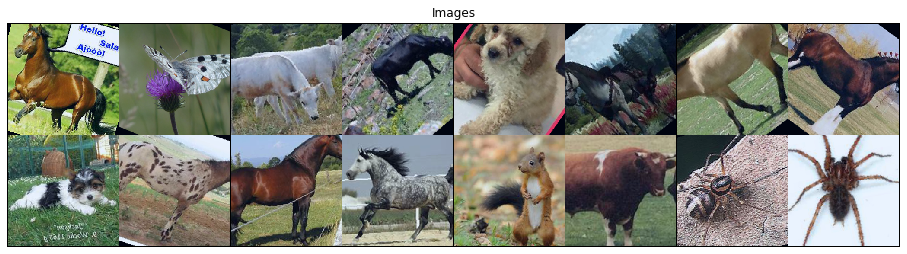

In [7]:
PlotSamples(train_dataloader)

### Defile Model Architecture

In [9]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3), nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

        ).to(device)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(4096, 256),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(256, 10)
        ).to(device)
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


model = MyModel().to(device)
#summary(model, (3,256,256))
model

MyModel(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (16): ReLU()
    (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (18): ReLU()
    (19): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (20): Conv2d(128

### Training Procedure

In [10]:
def Train(epoch, print_every=50):
    total_loss = 0
    start_time = time()
    
    accuracy = []
    
    for i, batch in enumerate(train_dataloader, 1):
        minput = batch[0].to(device) # Get batch of images from our train dataloader
        target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
        
        moutput = model(minput) # output by our model
        
        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters
        
        argmax = moutput.argmax(dim=1) # Get the class index with maximum probability predicted by the model
        accuracy.append((target==argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor

        if i%print_every == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time 
            ))
    
    return total_loss / len(train_dataloader) # Returning Average Training Loss

### Testing Procedure

In [11]:
def Test(epoch):
    total_loss = 0
    start_time = time()

    accuracy = []
    
    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        for i, batch in enumerate(test_dataloader):
            minput = batch[0].to(device) # Get batch of images from our test dataloader
            target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
            moutput = model(minput) # output by our model

            loss = criterion(moutput, target) # compute cross entropy loss
            total_loss += loss.item()
            
            
            # To get the probabilities for different classes we need to apply a softmax operation on moutput 
            argmax = moutput.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)
            accuracy.append((target==argmax).sum().item() / target.shape[0]) # Find the accuracy of the batch by comparing it with actual targets
            
    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-start_time
    ))
    return total_loss/len(test_dataloader) # Returning Average Testing Loss

### Model, Optimizer & Loss Function

In [12]:
lr = 0.0001
model = MyModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

### Train for 50 epochs

In [13]:
Test(0)

train_loss = []
test_loss = []

for epoch in range(1, 51):
    train_loss.append(Train(epoch,200))
    test_loss.append(Test(epoch))

    print('\n')
    
    if epoch % 10 == 0:
        torch.save(model, 'model_'+str(epoch)+'.pth')

Epoch: [0], Test Loss: 2.3070, Accuracy: 0.07, Time: 56.95 sec
Epoch: [1]/(200/1313), Train Loss: 2.2046, Accuracy: 0.18, Time: 84.78 sec
Epoch: [1]/(400/1313), Train Loss: 2.2835, Accuracy: 0.18, Time: 168.82 sec
Epoch: [1]/(600/1313), Train Loss: 2.3058, Accuracy: 0.18, Time: 252.27 sec
Epoch: [1]/(800/1313), Train Loss: 2.2410, Accuracy: 0.18, Time: 335.37 sec
Epoch: [1]/(1000/1313), Train Loss: 2.0531, Accuracy: 0.19, Time: 418.87 sec
Epoch: [1]/(1200/1313), Train Loss: 2.1373, Accuracy: 0.19, Time: 502.64 sec
Epoch: [1], Test Loss: 2.0828, Accuracy: 0.26, Time: 43.12 sec


Epoch: [2]/(200/1313), Train Loss: 2.3544, Accuracy: 0.27, Time: 86.74 sec
Epoch: [2]/(400/1313), Train Loss: 1.9280, Accuracy: 0.28, Time: 173.10 sec
Epoch: [2]/(600/1313), Train Loss: 2.4263, Accuracy: 0.28, Time: 259.71 sec
Epoch: [2]/(800/1313), Train Loss: 1.9702, Accuracy: 0.28, Time: 345.38 sec
Epoch: [2]/(1000/1313), Train Loss: 2.1264, Accuracy: 0.29, Time: 431.64 sec
Epoch: [2]/(1200/1313), Train Loss:

KeyboardInterrupt: 

### Plot Train-Test Loss Curve

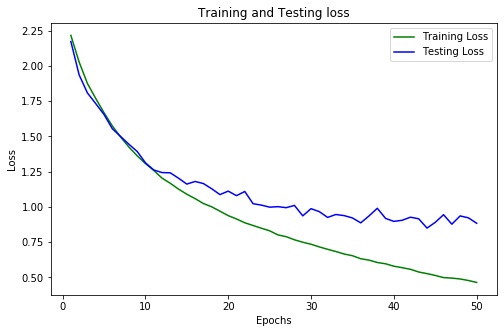

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss)+1), train_loss, 'g', label='Training Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, 'b', label='Testing Loss')

plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test on some random images

In [ ]:
translate = {
    "cane": "dog", 
    "cavallo": "horse", 
    "elefante": "elephant", 
    "farfalla": "butterfly", 
    "gallina": "chicken", 
    "gatto": "cat", 
    "mucca": "cow", 
    "pecora": "sheep", 
    "ragno": "spider",
    "scoiattolo": "squirrel",
}

translate = {x:translate[x] for x in train_dataloader.dataset.dataset.classes}

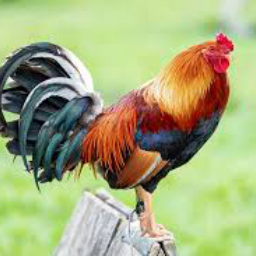

chicken : 100 % 




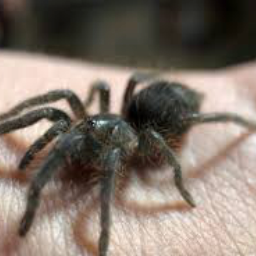

spider : 98 % 




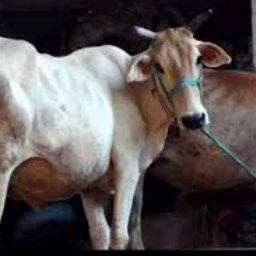

dog : 65 % 




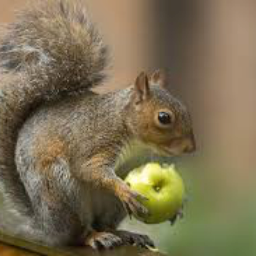

squirrel : 98 % 




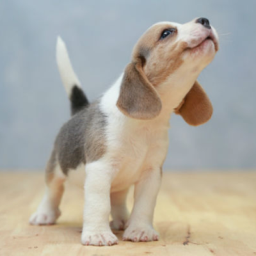

dog : 97 % 




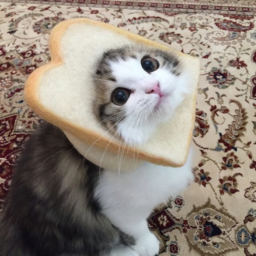

cat : 77 % 




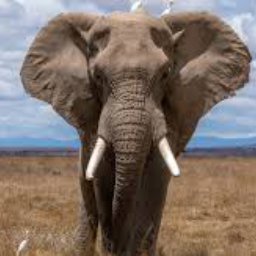

elephant : 99 % 




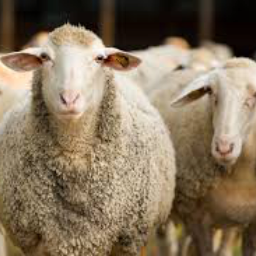

sheep : 99 % 




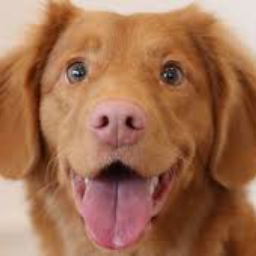

dog : 98 % 




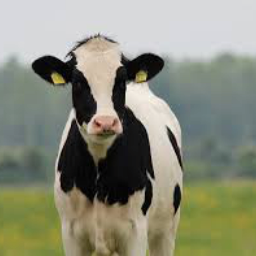

horse : 40 % 




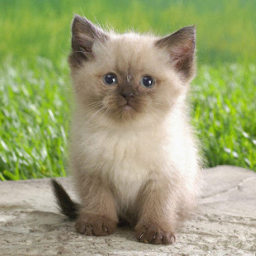

dog : 86 % 




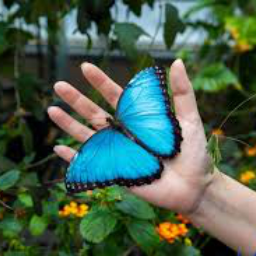

butterfly : 99 % 




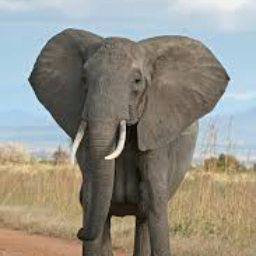

elephant : 100 % 




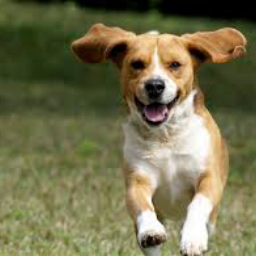

dog : 100 % 




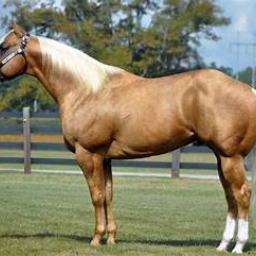

horse : 99 % 




In [ ]:
# # Uncomment the below two lines if you want to use the pre trained model for 50 epoch
# model = torch.load('BasicCNN_Pytorch/model_50.pth', map_location=device) 
# model.eval()


denormalize = transforms.Compose([
    transforms.Normalize(mean = -mean/std, std = 1./std),
    transforms.ToPILImage()
])


with torch.no_grad():

    for impath in os.listdir('BasicCNN_Pytorch/test_images/'):
        try:
            image = Image.open(f'BasicCNN_Pytorch/test_images/{impath}')
        except:
            continue

        image = transforms.Compose([
            transforms.Resize(256),  
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])(image)

        image_tensor = image.view(1,3,256,256).to(device)

        moutput = model(image_tensor)
        moutput = nn.Softmax(dim=1)(moutput)[0]*100
        
        idx = moutput.argmax().data.item()
        oclass = list(translate.keys())[idx]
        moutput = moutput.int().data.cpu().numpy()

        display(denormalize(image))
        print(translate[oclass], ':', moutput[idx], '%', '\n\n')

model.train()
pass

### Try Training for another 50 epochs

In [ ]:
model.train()

for epoch in range(51,101):
    train_loss.append(Train(epoch,94))
    test_loss.append(Test(epoch))

    print('\n')
    
    if epoch % 10 == 0:
        torch.save(model, 'model_'+str(epoch)+'.pth')

Epoch: [51]/(94/1313), Train Loss: 0.3074, Accuracy: 0.86, Time: 8.80 sec
Epoch: [51]/(188/1313), Train Loss: 0.3984, Accuracy: 0.86, Time: 17.49 sec
Epoch: [51]/(282/1313), Train Loss: 0.5296, Accuracy: 0.85, Time: 26.32 sec
Epoch: [51]/(376/1313), Train Loss: 0.6989, Accuracy: 0.86, Time: 33.97 sec
Epoch: [51]/(470/1313), Train Loss: 0.4635, Accuracy: 0.86, Time: 41.99 sec
Epoch: [51]/(564/1313), Train Loss: 0.3324, Accuracy: 0.85, Time: 50.50 sec
Epoch: [51]/(658/1313), Train Loss: 0.7592, Accuracy: 0.85, Time: 59.71 sec
Epoch: [51]/(752/1313), Train Loss: 0.5850, Accuracy: 0.85, Time: 69.12 sec
Epoch: [51]/(846/1313), Train Loss: 0.5018, Accuracy: 0.85, Time: 77.41 sec
Epoch: [51]/(940/1313), Train Loss: 0.5039, Accuracy: 0.85, Time: 85.96 sec
Epoch: [51]/(1034/1313), Train Loss: 0.5657, Accuracy: 0.85, Time: 95.31 sec
Epoch: [51]/(1128/1313), Train Loss: 0.3155, Accuracy: 0.85, Time: 102.97 sec
Epoch: [51]/(1222/1313), Train Loss: 0.3265, Accuracy: 0.85, Time: 111.42 sec
Epoch: [5

### Test the same Images

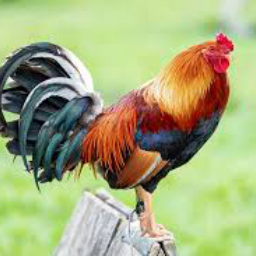

chicken : 100 % 




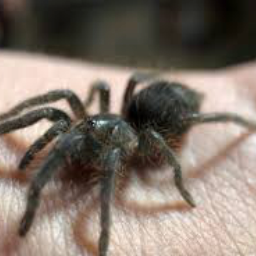

spider : 99 % 




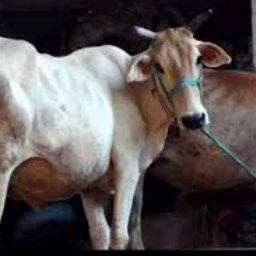

cow : 79 % 




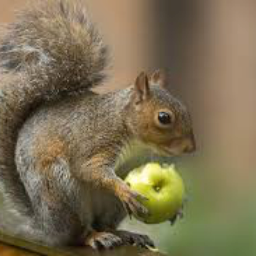

squirrel : 100 % 




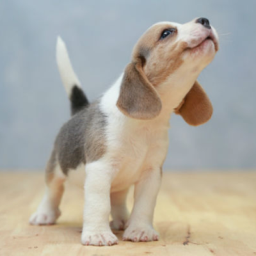

dog : 99 % 




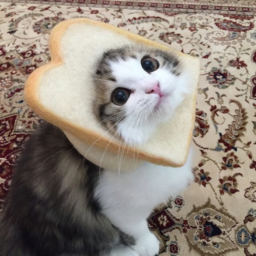

cat : 99 % 




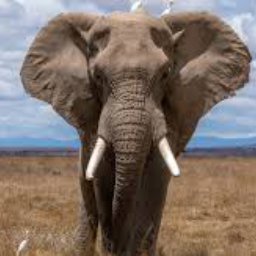

elephant : 100 % 




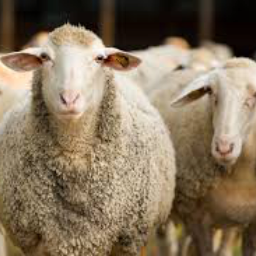

sheep : 99 % 




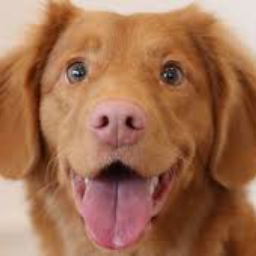

dog : 99 % 




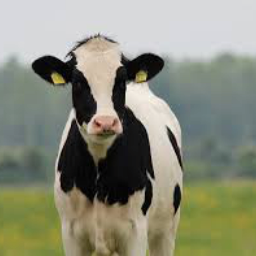

cow : 42 % 




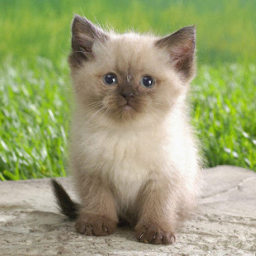

cat : 89 % 




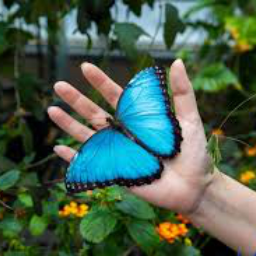

butterfly : 99 % 




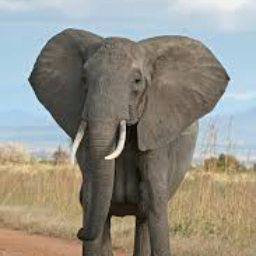

elephant : 100 % 




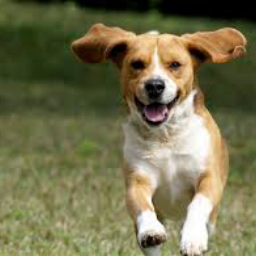

dog : 100 % 




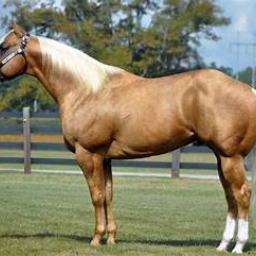

horse : 99 % 




In [ ]:
# # Uncomment the below two lines if you want to use the pre trained model for 100 epoch
# model = torch.load('BasicCNN_Pytorch/model_100.pth', map_location=device)
# model.eval()

denormalize = transforms.Compose([
    transforms.Normalize(mean = -mean/std, std = 1./std),
    transforms.ToPILImage()
])


with torch.no_grad():

    for impath in os.listdir('BasicCNN_Pytorch/test_images/'):
        try:
            image = Image.open(f'BasicCNN_Pytorch/test_images/{impath}')
        except:
            continue

        image = transforms.Compose([
            transforms.Resize(256),  
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])(image)

        image_tensor = image.view(1,3,256,256).to(device)

        moutput = model(image_tensor)
        moutput = nn.Softmax(dim=1)(moutput)[0]*100
        
        idx = moutput.argmax().data.item()
        oclass = list(translate.keys())[idx]
        moutput = moutput.int().data.cpu().numpy()

        display(denormalize(image))
        print(translate[oclass], ':', moutput[idx], '%', '\n\n')

model.train()
pass